# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [12]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [13]:
df_offers = pd.read_excel("data/WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [14]:
df_transactions = pd.read_excel("data/WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [15]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB


In [16]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
customer_name    324 non-null object
offer_id         324 non-null int64
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


In [17]:
df_merged = pd.merge(df_offers, df_transactions, how='outer', on='offer_id')
df_merged.head(n=3)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1


In [18]:
df_customer = df_merged.pivot_table(index='customer_name', columns='offer_id', values='n', aggfunc=lambda x:len(x.unique()), fill_value=0)
df_customer.head(n=3)

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [19]:
df_customer.shape

(100, 32)

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

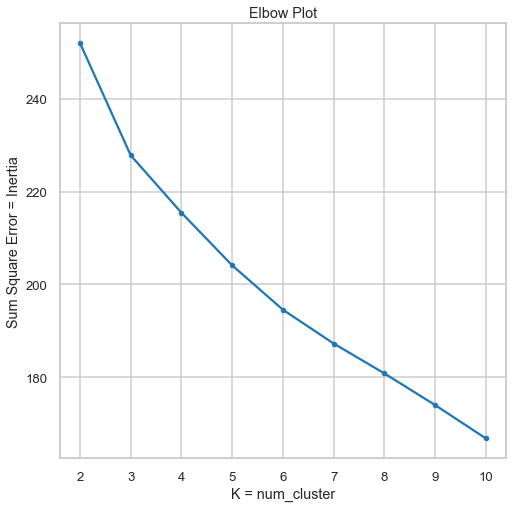

In [20]:
from sklearn.cluster import KMeans

x_cols = np.array(df_customer.iloc[:, :32])
ss = [];
ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(x_cols)
    ss.append(kmeans.inertia_)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(ks, ss, marker='.')
axes.set(xlabel='K = num_cluster', ylabel = 'Sum Square Error = Inertia', title = 'Elbow Plot')
plt.show()

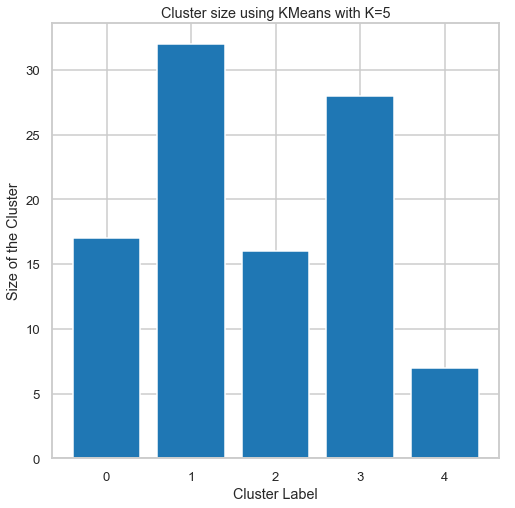

In [21]:
# Pick 5 clusters
kmeans = KMeans(n_clusters=5, random_state=2)
df_customer['labels'] = kmeans.fit_predict(x_cols)
cluster_size = df_customer.labels.value_counts()
f, axes = plt.subplots(figsize=(8, 8))
axes.bar(cluster_size.index, cluster_size)
axes.set(xlabel='Cluster Label', ylabel='Size of the Cluster', title='Cluster size using KMeans with K=5')
plt.show()
df_customer = df_customer.drop('labels', axis=1)

<div class="span5 alert alert-success">
The Sum Square error decreases with K and from the elbow plot, it often becomes difficult to select the optimal or the right choice for K.
</div>

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

n_cluster=3, Average silhouette score = 0.121
n_cluster=4, Average silhouette score = 0.127
n_cluster=5, Average silhouette score = 0.141
n_cluster=6, Average silhouette score = 0.125
n_cluster=7, Average silhouette score = 0.133
n_cluster=8, Average silhouette score = 0.133
n_cluster=9, Average silhouette score = 0.104
n_cluster=10, Average silhouette score = 0.118


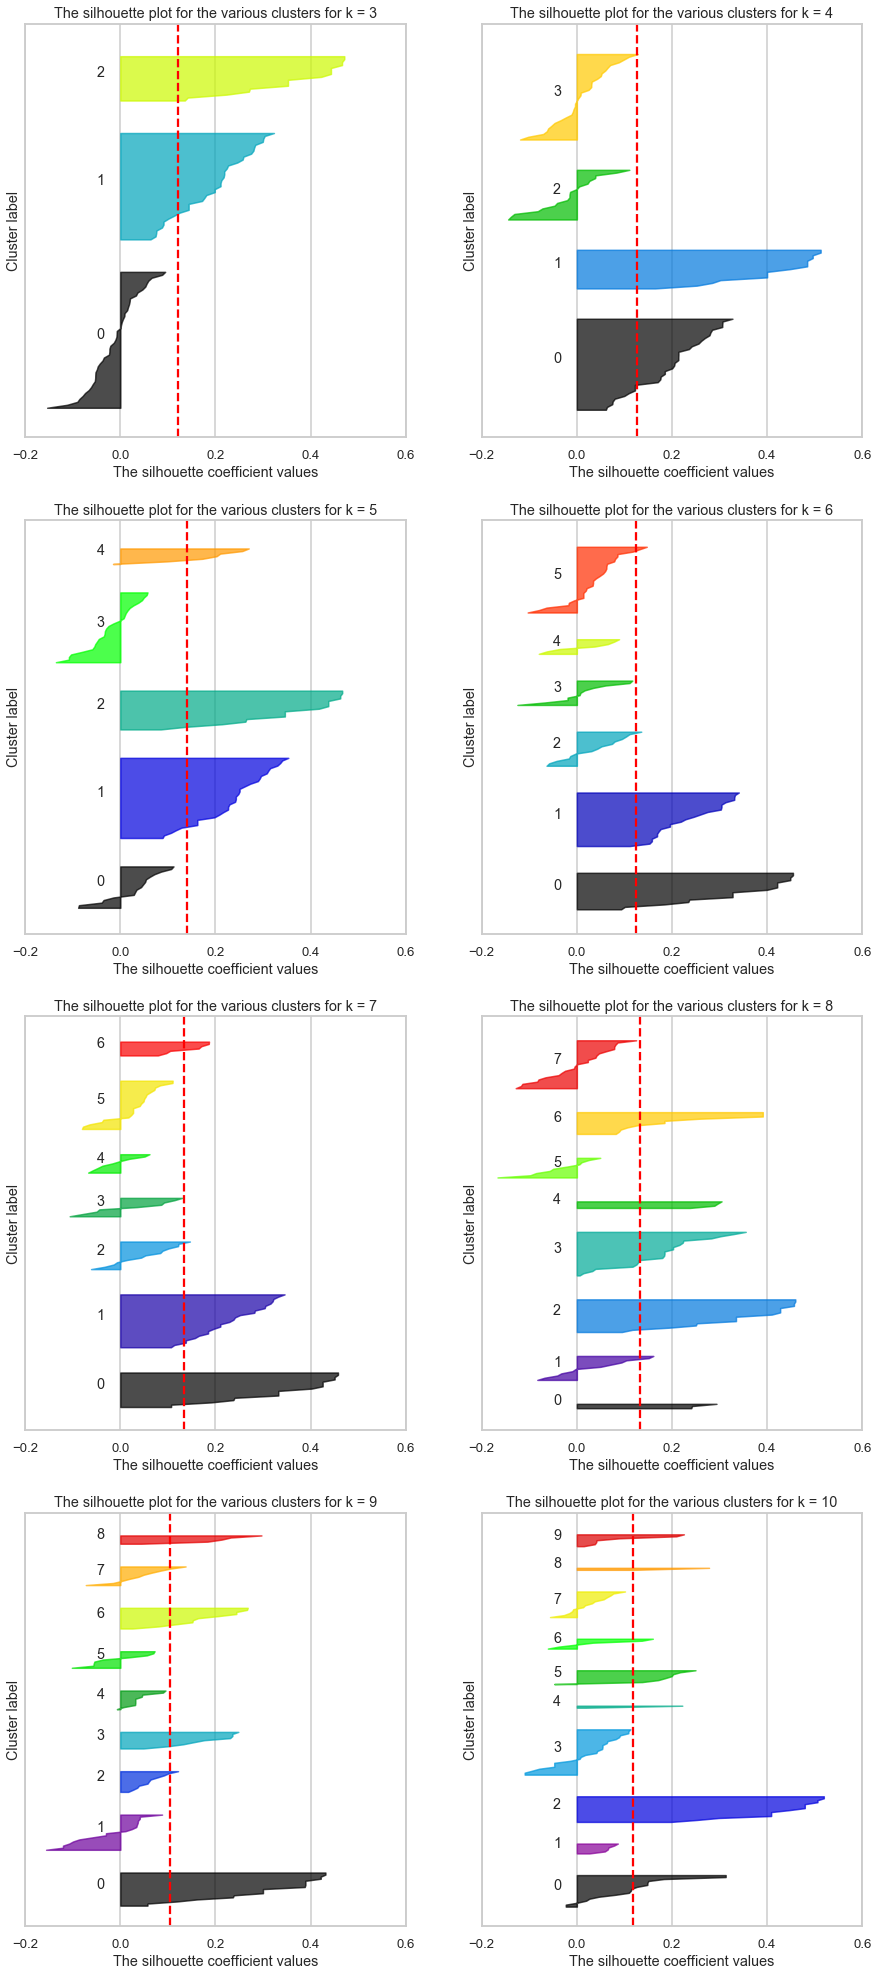

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
ks = range(3, 11)
f, axes = plt.subplots(len(ks)//2, 2, figsize=(15, 35))
silhouette_avg = []
for idx, k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(x_cols)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg.append(silhouette_score(x_cols, labels))
    print('n_cluster={0}, Average silhouette score = {1:.3f}'.format(k, silhouette_avg[-1]))
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, labels)
    
    # xlim: The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 0.6]
    # ylim: The (n_clusters+1)*10 is for inserting blank space between silhouette 
    # plots of individual clusters, to demarcate them clearly.
    axes[idx//2, idx%2].set(xlim=[-0.2, 0.6], ylim=[0, len(x_cols)+(k+1)*10])
    y_lower=10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        axes[idx//2, idx%2].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axes[idx//2, idx%2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    axes[idx//2, idx%2].set(xlabel='The silhouette coefficient values', ylabel='Cluster label')
    axes[idx//2, idx%2].set(title='The silhouette plot for the various clusters for k = {}'.format(k))
    axes[idx//2, idx%2].axvline(x=silhouette_avg[-1], color='red', linestyle='--')
    axes[idx//2, idx%2].set(yticks=[], xticks=[-0.2, 0, 0.2, 0.4, 0.6])

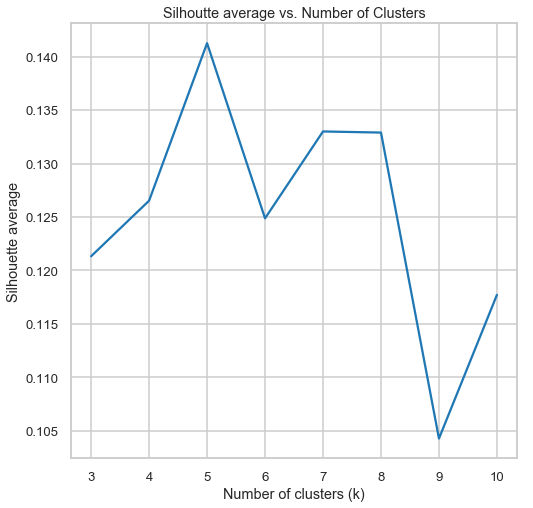

In [23]:
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(ks, silhouette_avg)
axes.set(xlabel='Number of clusters (k)',ylabel = 'Silhouette average', title ='Silhoutte average vs. Number of Clusters')
plt.show()

<div class="span5 alert alert-success">

From the above silhoutte average plot, it does look like best choice for the number of clusters = 5. However, the absolute value of the average is <0.25 which seems to indicate that we didnt really find any substantial structure in the cluster. 
Also, there seems to be several negative silhoutte sample values (as seen from the silhouette plot for n_clusters = 5). These negative values indicate that the cluster that has been chosen for those data points might be incorrectly assigned. 
</div>

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

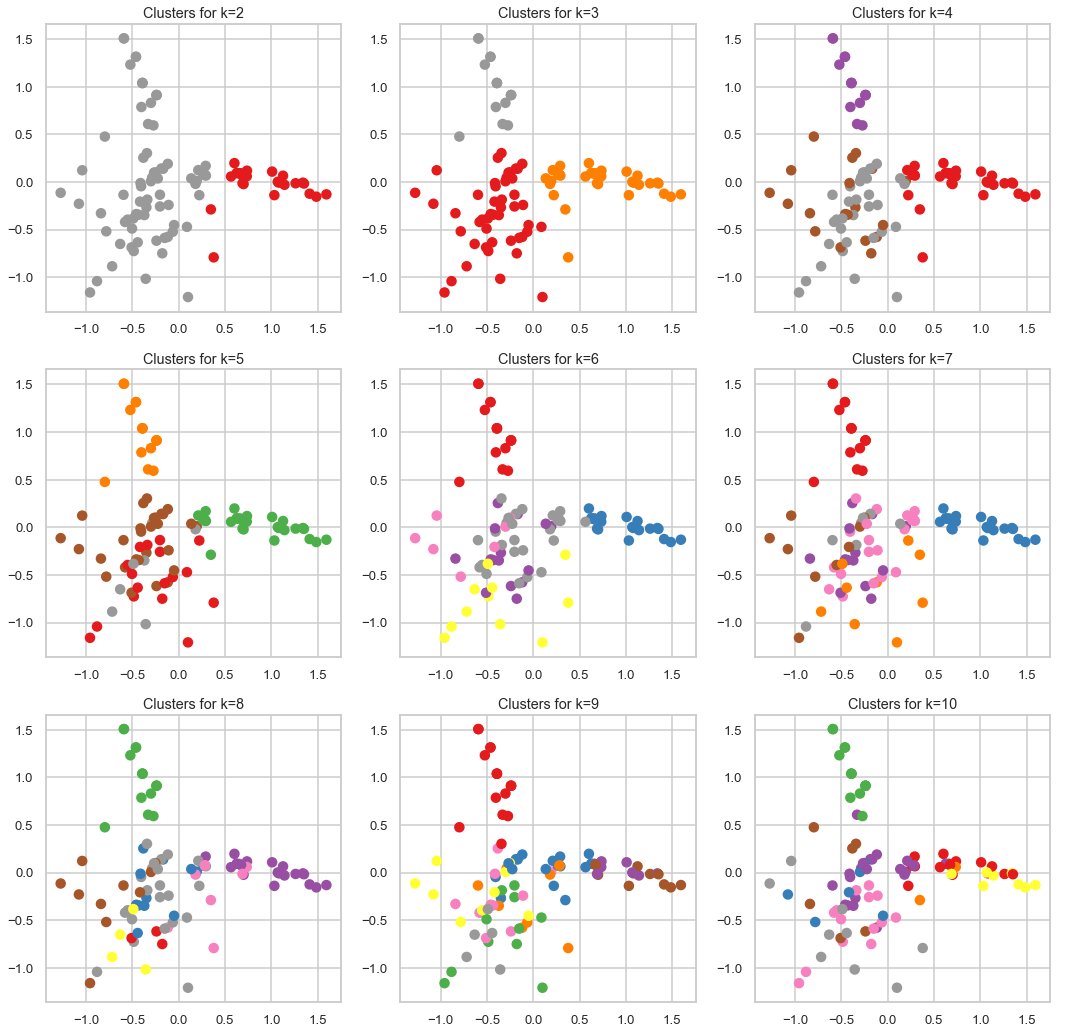

In [24]:
from sklearn.decomposition import PCA
import matplotlib

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x_cols)
df_pca = pd.DataFrame({'customer_name':df_customer.index, 'x':pca_transformed[:,0], 'y':pca_transformed[:,1]})

ks = range(2, 11)
fig = plt.figure(figsize=(18, 18))
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(x_cols)
    axes = fig.add_subplot(3, 3, k-1)
    axes.scatter(df_pca.x, df_pca.y, c=labels, cmap='Set1')
    axes.set(title='Clusters for k={}'.format(k))


<div class="span5 alert alert-success">

From the above PCA cluster plots, num_cluster = 3 seems like a good choice with clusters corresponding to 
1. with high PCA x component, 
2. with high PCA y-component and 
3. with low x and y PCA component. 

While the silhouette method seemed to suggest K=5, the elbow method didnt give a clear choice for K. However picking up the number of components based on PCA might not be the best, since we have discarded information by reducing the overal dimension from 32 to 2. Howver, let us analyze with 3 clusters. 
</div>

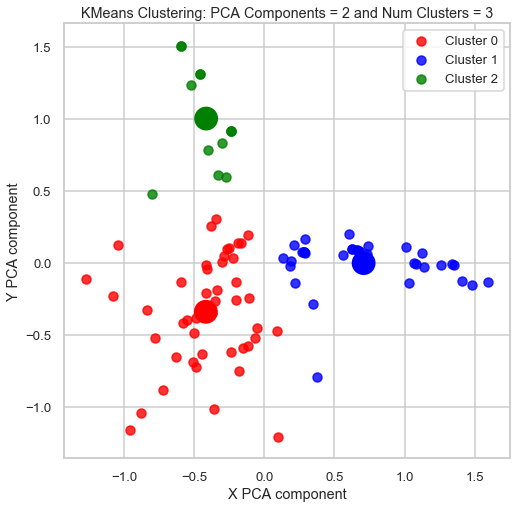

In [52]:
# Pick 3 clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=2)
labels = kmeans.fit_predict(x_cols)

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x_cols)
cluster_centers = pca.transform(kmeans.cluster_centers_)

df_pca = pd.DataFrame({'customer_name':df_customer.index, 'cluster_id':labels, 'x':pca_transformed[:,0], 'y':pca_transformed[:,1]})
df_cluster_center = pd.DataFrame({'x': cluster_centers[:,0], 'y':cluster_centers[:,1]})

colors = ['r', 'b', 'g']
f, axes = plt.subplots(figsize=(8, 8))
for i in range(k):
    axes.scatter(df_pca[df_pca['cluster_id']==i].x, df_pca[df_pca['cluster_id']==i].y, c=colors[i], alpha=0.8, label='Cluster '+str(i))
axes.scatter(cluster_centers[:,0], cluster_centers[:,1], c=colors, s=500)
axes.set(xlabel='X PCA component', ylabel='Y PCA component', title='KMeans Clustering: PCA Components = 2 and Num Clusters = 3')
axes.legend()
plt.show()

<div class="span5 alert alert-success">

The above cluster plot indicates a reasonably strong characteristics associated with customers in Cluster 1 and Cluster 2, respectively. Customers belonging to Cluster 0 have reasonably high variance in their behavior. The 3 cluster categories correspond to - 
1. with high PCA x-component,
2. with high PCA y-component and
3. rest of the customers.
</div>

<div class="span5 alert alert-success">

<h3>Looking at each Cluster Characteristics</h3>

</div>

In [26]:
df = pd.merge(df_pca, df_merged, how='outer', on = 'customer_name')
wine_dict = {'Espumante':'White', 'Pinot Grigio':'Red', 'Malbec':'Red', 'Chardonnay':'White', 'Champagne':'White', 'Pinot Noir':'Red', 'Prosecco':'White', 'Cabernet Sauvignon':'Red', 'Merlot':'Red'}
df['is_red']=df.varietal.map(wine_dict)

continent_dict = {'Oregon':'N America', 'France':'Europe', 'Chile':'S America', 'New Zealand':'Australia', 'Italy':'Europe', 'Australia':'Australia', 'California':'N America', 'Germany':'Europe', 'South Africa':'Africa'}
df['continent']=df.origin.map(continent_dict)

month_dict = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
df['month']=df.campaign.map(month_dict)
df.head()

,cluster_id,customer_name,x,y,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,n,is_red,continent,month
0,1,Adams,1.007580,0.108215,18,July,Espumante,6,50,Oregon,False,1,White,N America,7
1,1,Adams,1.007580,0.108215,29,November,Pinot Grigio,6,87,France,False,1,Red,Europe,11
2,1,Adams,1.007580,0.108215,30,December,Malbec,6,54,France,False,1,Red,Europe,12
3,0,Allen,-0.287539,0.044715,9,April,Chardonnay,144,57,Chile,False,1,White,S America,4
4,0,Allen,-0.287539,0.044715,27,October,Champagne,72,88,New Zealand,False,1,White,Australia,10


In [27]:
df_groupby = df.groupby('cluster_id')
df_groupby['campaign'].count()

cluster_id
0    179
1    102
2     43
Name: campaign, dtype: int64

<div class="span5 alert alert-success">

Clusters are imbalanced with 55% of the data points falling into Cluster 0, 31% of data points into Cluster 1 and the remaining 14% in the final Cluster 2
</div>

In [28]:
df.pivot_table(index='cluster_id', columns='month', values='n', aggfunc='count', fill_value=0, margins=True)

month,1,2,3,4,5,6,7,8,9,10,11,12,All
cluster_id,,,,,,,,,,,,,
0,13,20,17,13,15,18,5,28,4,15,6,25,179
1,0,2,34,3,8,1,14,3,0,2,17,18,102
2,7,0,0,1,1,1,7,0,13,13,0,0,43
All,20,22,51,17,24,20,26,31,17,30,23,43,324


<div class="span5 alert alert-success">
Most sales are reported during the months of March, December and August; however, Cluster 2 customers do not purchase wine during those 3 months. 
</div>

In [29]:
df.pivot_table(index='cluster_id', columns='origin', values='n', aggfunc='count', fill_value=0)

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster_id,,,,,,,,,
0,9,9,29,84,8,12,11,10,7
1,17,5,8,37,1,0,1,16,17
2,13,2,0,7,7,12,1,0,1


In [30]:
df.pivot_table(index='cluster_id', columns='continent', values='n', aggfunc='count', fill_value=0)

continent,Africa,Australia,Europe,N America,S America
cluster_id,,,,,
0,7,20,104,19,29
1,17,18,38,21,8
2,1,14,26,2,0


<div class="span5 alert alert-success">
Cluster 2 customers are primarily from Australia and Europe.
</div>

In [31]:
#pd.crosstab(df.cluster_id, df.varietal)
df.pivot_table(index='cluster_id', columns='varietal', values='n', aggfunc='count', fill_value=0)

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster_id,,,,,,,,,
0,30,74,13,8,13,12,1,7,21
1,2,6,1,32,18,7,16,0,20
2,0,1,1,0,1,1,0,37,2


In [32]:
df.pivot_table(index='cluster_id', columns='is_red', values='n', aggfunc='count', fill_value=0)

is_red,Red,White
cluster_id,,
0,63,116
1,43,59
2,39,4


<div class="span5 alert alert-success">

Barring couple of outliers
* Cluster 2 customers prefer Red wine, and Pinot Noir in particular. 
* Cluster 1 user are the only users who purchase Pinot Grigio
* Cabernet Sauvignon, Chardonnay are primarily purchased by Cluster 0 customers 
</div>

In [33]:
df.pivot_table(index='cluster_id', columns='past_peak', values='n', aggfunc='count', fill_value=0)

past_peak,False,True
cluster_id,,
0,142,37
1,82,20
2,43,0


<div class="span5 alert alert-success">
Cluster 2 customers do NOT purchase any wine that is past its peak. 
</div>

In [34]:
df.pivot_table(index='cluster_id', columns='min_qty', values='n', aggfunc='count', fill_value=0)

min_qty,6,12,72,144
cluster_id,,,,
0,12,11,115,41
1,86,4,8,4
2,12,7,11,13


In [35]:
df_groupby.min_qty.mean()

cluster_id
0    80.379888
1    16.823529
2    65.581395
Name: min_qty, dtype: float64

<div class="span5 alert alert-success">

Cluster 1 customers tend to purchase wines if offers are made for lower minimum quantity requirements. While Culster 0 customers purchase in larger quantities. 
</div>

In [36]:
df_groupby.discount.agg([min, 'mean', 'max'])

,min,mean,max
cluster_id,,,
0,17,63.435754,89
1,32,55.647059,88
2,17,52.116279,88


<div class="span5 alert alert-success">

No trend observed here. Customer in all the 3 groups react similarly with respect to the discount offered on the wine. 
</div>

<div class="span5 alert alert-success">

<h3>Summary for the 3 Customer Clusters</h3>

Cluster 0 Customers: 
* All the Cabernet Sauvignon and Chardonnayo purchases were made by these customer
* These customers purchase wines in larger quantities

Cluster 1 Customers: 
* All the Pinot Grigio purchases were made by these customer 
* They tend to purchase wines if offers are made for lower minimum quantity requirements. 

Cluster 2 Customers: 
* They are primarily from Australia and Europe
* Though most sales are reported during the months of March, December and August these customers do not purchase wine during those 3 months
* They prefer Red wine, and Pinot Noir in particular.
* They do NOT purchase any wine that is past its peak.

</div>

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

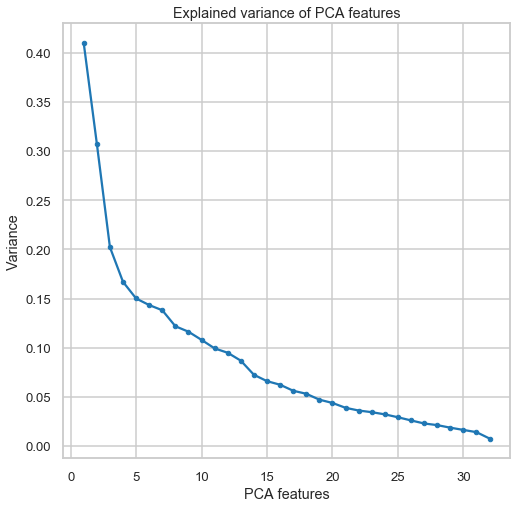

In [37]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(range(1, pca.n_components_+1), pca.explained_variance_, marker = '.')
axes.set(xlabel = 'PCA features', ylabel='Variance', title='Explained variance of PCA features')
plt.show()

<div class="span5 alert alert-success">

From the above plot, there is a significant decrease in the explained variance for the 3rd component. So, based on the above figure, 2 clusters seems like a good choice. The % decrease in the explained variance 4th component onwards is not a lot. So, we could either use number of components as 2 or 3 from the above figure.
</div>

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


<div class="span5 alert alert-success">

<h2>Affinity Propagation</h2>
</div>

In [55]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

algo_sil_score = pd.DataFrame(index=['Affinity Propagation', 'Spectral Clustering', 'Agglomerative Clustering', 'DBSCAN'])
algo_sil_score['algo_avg_silhouette_score']=0
algo_sil_score['cluster_size']=0

d_range = [0.5, 0.6, 0.7, 0.8, 0.9]
p_range = [-30, -20, -10, 0, 10]

max_sil_score = -np.inf
best_d, best_p = None, None
for d in d_range:
    for p in p_range:
        af = AffinityPropagation(preference=p, damping=d)
        labels = af.fit_predict(x_cols)
        if len(np.unique(labels))==1 or len(np.unique(labels))==len(labels):
            continue
        score = metrics.silhouette_score(x_cols, labels)
        (best_d, best_p, max_sil_score) = (d, p, score) if score>max_sil_score else (best_d, best_p, max_sil_score)
        # print(d, p, score, max_sil_score)
print('Best damping = {0:.1f}, Best preference = {1:d}, Best silhouette score = {2:.3f}'.format(best_d, best_p, max_sil_score))
af = AffinityPropagation(preference=best_p, damping=best_d)
labels = af.fit_predict(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: {}'.format(n_clusters_))
print('Average Silhouette Score: {0:.3f}'.format(metrics.silhouette_score(x_cols, labels)))
algo_sil_score.loc['Affinity Propagation'] = [max_sil_score, n_clusters_]

Best damping = 0.6, Best preference = -10, Best silhouette score = 0.110
Estimated number of clusters: 9
Average Silhouette Score: 0.110


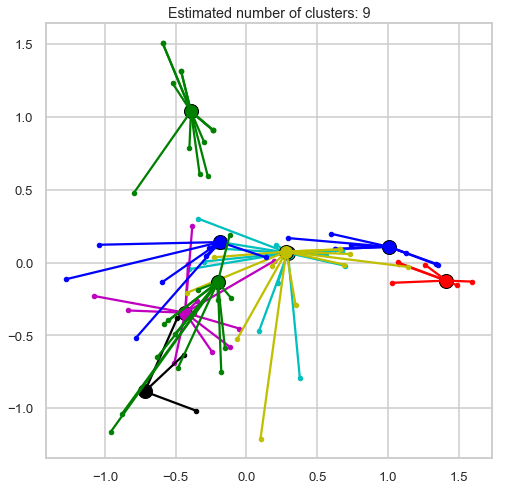

In [56]:
# Plot using PCA components
from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
plt.figure(figsize=(8, 8))
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center_x = df_pca.x[cluster_centers_indices[k]]
    cluster_center_y = df_pca.y[cluster_centers_indices[k]]
    plt.plot(df_pca.x[class_members], df_pca.y[class_members], col + '.')
    plt.plot(cluster_center_x, cluster_center_y, 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x, y in zip(df_pca.x[class_members], df_pca.y[class_members]):
        plt.plot([cluster_center_x, x], [cluster_center_y, y], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

<div class="span5 alert alert-success">

<h2>Spectral Clustering</h2>
</div>

In [40]:
from sklearn.cluster import SpectralClustering

k_range = range(2, 11)
max_sil_score = -np.inf
best_k = None, 
for k in k_range:
    sc = SpectralClustering(n_clusters=k)
    labels = sc.fit_predict(x_cols)
    score = metrics.silhouette_score(x_cols, labels)
    (best_k, max_sil_score) = (k, score) if score>max_sil_score else (best_k, max_sil_score)
    #print(d, p, score, max_sil_score)
print('Best num cluster = {0:d}, Best silhouette score = {1:.3f}'.format(best_k, max_sil_score))

sc = SpectralClustering(n_clusters=best_k)
labels = sc.fit_predict(x_cols)
print('Average Silhouette Score: {0:.3f}'.format(metrics.silhouette_score(x_cols, labels)))
algo_sil_score.loc['Spectral Clustering'] = [max_sil_score, best_k]

Best num cluster = 3, Best silhouette score = 0.100
Average Silhouette Score: 0.100


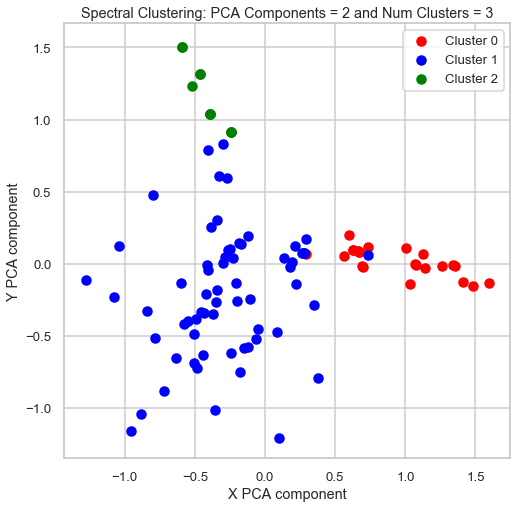

In [41]:
# Plot using PCA Components to see how the Spectral Clustering looks like
colors = ['r', 'b', 'g']
f, axes = plt.subplots(figsize=(8, 8))
for i in range(best_k):
    axes.scatter(df_pca[labels==i].x, df_pca[labels==i].y, c=colors[i], label='Cluster '+str(i))
axes.set(xlabel='X PCA component', ylabel='Y PCA component', title='Spectral Clustering: PCA Components = 2 and Num Clusters = 3')
axes.legend()
plt.show()


<div class="span5 alert alert-success">

Though the number of clusters are the same for most of these clustering algorithms, the points being assigned to these clusters, are different. Hence, we see varying silhouette score. 
</div>

<div class="span5 alert alert-success">

<h2>Agglomerative Clustering</h2>
</div>

In [42]:
from sklearn.cluster import AgglomerativeClustering

k_range = range(2, 11)
l_types = ['ward', 'complete', 'average']
#l_types = ['complete']
max_sil_score = -np.inf
best_k, best_l = None, None
for k in k_range:
    for l in l_types:
        ac = AgglomerativeClustering(n_clusters=k, linkage=l)
        labels = ac.fit_predict(x_cols)
        score = metrics.silhouette_score(x_cols, labels)
        (best_k, best_l, max_sil_score) = (k, l, score) if score>max_sil_score else (best_k, best_l, max_sil_score)
        #print(k, l, score, max_sil_score)
print('Best num cluster = {0:d}, Best linkage = {1}, Best silhouette score = {2:.3f}'.format(best_k, best_l, max_sil_score))

ac = AgglomerativeClustering(n_clusters=best_k, linkage=best_l)
labels = ac.fit_predict(x_cols)
print('Average Silhouette Score: {0:.3f}'.format(metrics.silhouette_score(x_cols, labels)))
algo_sil_score.loc['Agglomerative Clustering'] = [max_sil_score, best_k]

Best num cluster = 2, Best linkage = complete, Best silhouette score = 0.235
Average Silhouette Score: 0.235


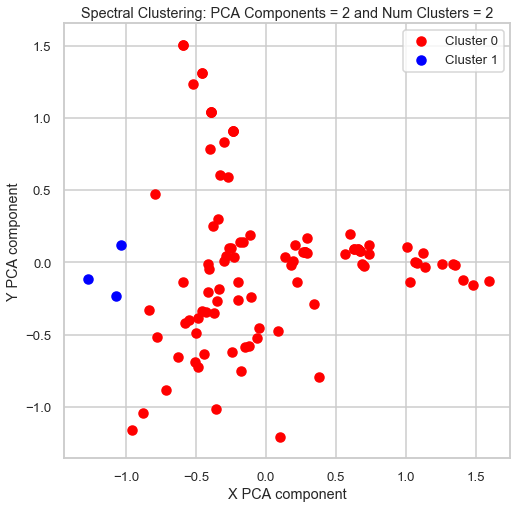

In [43]:
# Plot using PCA Components to see how the Spectral Clustering looks like
colors = ['r', 'b', 'g']
f, axes = plt.subplots(figsize=(8, 8))
for i in range(best_k):
    axes.scatter(df_pca[labels==i].x, df_pca[labels==i].y, c=colors[i], label='Cluster '+str(i))
axes.set(xlabel='X PCA component', ylabel='Y PCA component', title='Spectral Clustering: PCA Components = 2 and Num Clusters = 2')
axes.legend()
plt.show()

<div class="span5 alert alert-success">

<h2>DBSCAN</h2>
</div>

In [44]:
from sklearn.cluster import DBSCAN

e_range = [0.2, 0.3, 0.4, 0.5, 0.6]
s_range = [1, 2, 3]

max_sil_score = -np.inf
best_e, best_s = None, None
for e in e_range:
    for s in s_range:
        db = DBSCAN(eps=e, min_samples=s)
        labels = db.fit_predict(x_cols)
        if len(np.unique(labels))==1 or len(np.unique(labels))==len(labels):
            continue
        score = metrics.silhouette_score(x_cols, labels)
        (best_e, best_s, max_sil_score) = (e, s, score) if score>max_sil_score else (best_e, best_s, max_sil_score)
        # print(e, s, score, max_sil_score)
print('Best eps = {0:.1f}, Best min samples = {1:d}, Best silhouette score = {2:.3f}'.format(best_e, best_s, max_sil_score))

db = DBSCAN(eps=best_e, min_samples=best_s)
labels = db.fit_predict(x_cols)
n_clusters = len(set(labels))-(1 if -1 in labels else 0)
print('Estimated number of clusters: {}'.format(n_clusters))
print('Average Silhouette Score: {0:.3f}'.format(metrics.silhouette_score(x_cols, labels)))
algo_sil_score.loc['DBSCAN'] = [max_sil_score, n_clusters]

Best eps = 0.2, Best min samples = 1, Best silhouette score = 0.190
Estimated number of clusters: 89
Average Silhouette Score: 0.190


In [45]:
algo_sil_score.loc['KMeans + 3 clusters'] = [0.121, 3]
algo_sil_score.loc['KMeans + 5 clusters'] = [0.141, 5]
algo_sil_score

,algo_avg_silhouette_score,cluster_size
Affinity Propagation,0.110371,9.0
Spectral Clustering,0.099906,3.0
Agglomerative Clustering,0.234890,2.0
DBSCAN,0.190000,89.0
KMeans + 3 clusters,0.121000,3.0
KMeans + 5 clusters,0.141000,5.0


<div class="span5 alert alert-success">

<h2>Comapring all the algorithms</h2>

* Affinity Propagation is typically used when there are many clusters. It doesnt work really well for our example with just 100 observations. The number of customers in each cluster <10.  
* Spectral Clustering seems to pick an optimal cluster size of 3. However, the cluster composition yields a lower silhouette score compared to KMean + 3 clusters. The PCA cluster plot too seem to indicate that, the labeling might less accurate compared to KMean
* Agglomerative Clustering requires large samples. For our data, it surprisingly yields a higher silhoutte score with just 2 clusters compared to KMean. Upon inspecting the labels, we observe that only 3 customers have been labelled as Cluster 1 and all the remaining 97 customers have been labeled as Cluster 0. This is not the desired result.
* DBSCAN clearly doesnt work well for our case since it too requires large number of samples. Here we have only 100 samples. Though the silhouette score is high, the algorithm splits the data into 89 clusters which doesnt serve our purpose. 

</div>